In [20]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from keras.applications import InceptionV3
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [21]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

data_dir = r"D:\Datasets\FloodNet\Classification"
target_size = (224, 224)
batch_size = 32

# Assuming your data is organized in subdirectories by class
classes = sorted(os.listdir(data_dir))

# Initialize lists to store image arrays and corresponding labels
X_data = []
y_data = []

# Load images and labels
for class_label in classes:
    class_path = os.path.join(data_dir, class_label)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        X_data.append(img_array)
        y_data.append(classes.index(class_label))

# Convert lists to NumPy arrays
X_data = np.array(X_data)
y_data = np.array(y_data)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(classes))
y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(classes))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(classes))

In [22]:
# Base model setup
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Model construction
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Model compilation
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 23,903,010
Trainable params: 2,100,226
Non-trainable params: 21,802,784
__________________________________

In [23]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
9/9 [==============================] - 6s 234ms/step - loss: 1.1296 - accuracy: 0.8273 - val_loss: 0.4416 - val_accuracy: 0.8833
Epoch 2/30
9/9 [==============================] - 1s 61ms/step - loss: 0.3844 - accuracy: 0.8957 - val_loss: 0.4123 - val_accuracy: 0.8667
Epoch 3/30
9/9 [==============================] - 1s 59ms/step - loss: 0.2322 - accuracy: 0.9317 - val_loss: 0.2444 - val_accuracy: 0.9167
Epoch 4/30
9/9 [==============================] - 1s 58ms/step - loss: 0.1658 - accuracy: 0.9532 - val_loss: 0.2729 - val_accuracy: 0.9333
Epoch 5/30
9/9 [==============================] - 1s 58ms/step - loss: 0.1254 - accuracy: 0.9676 - val_loss: 0.3053 - val_accuracy: 0.9333
Epoch 6/30
9/9 [==============================] - 1s 59ms/step - loss: 0.1090 - accuracy: 0.9640 - val_loss: 0.2577 - val_accuracy: 0.9500
Epoch 7/30
9/9 [==============================] - 1s 59ms/step - loss: 0.0902 - accuracy: 0.9820 - val_loss: 0.3293 - val_accuracy: 0.9333
Epoch 8/30
9/9 [==========

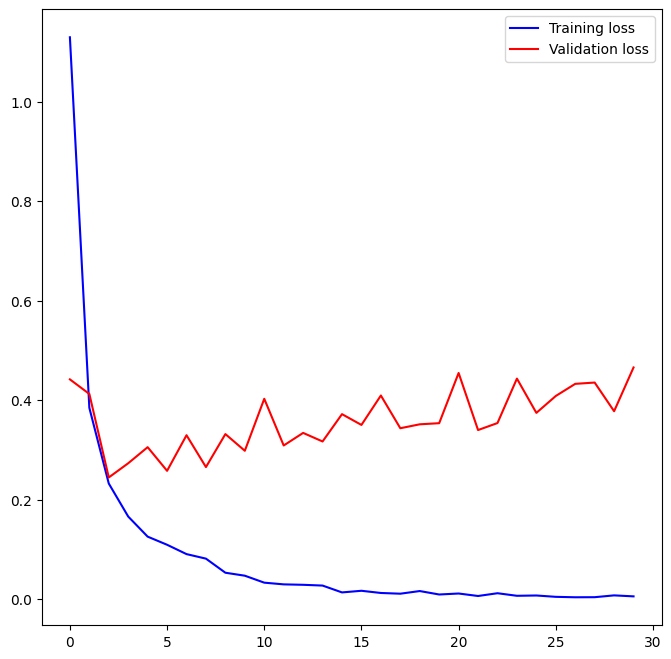

<Figure size 640x480 with 0 Axes>

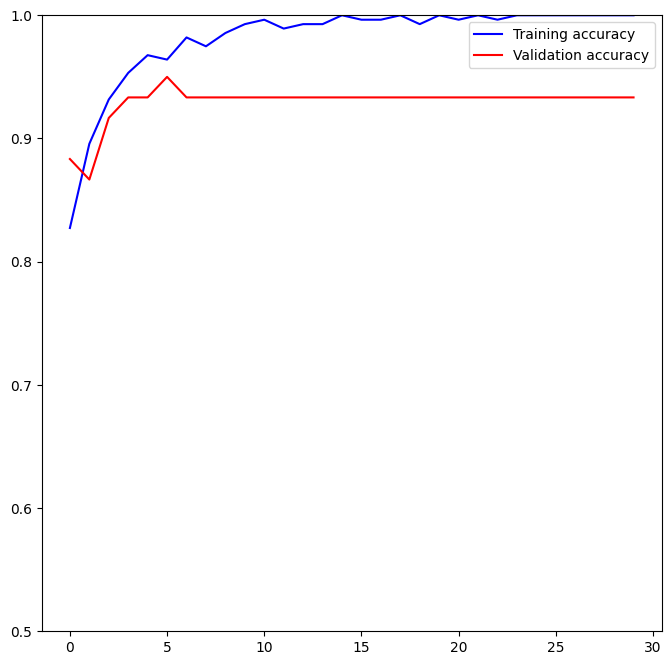

In [24]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.ylim(0.5, 1)
plt.show()

### Test data of FloodNet

In [26]:
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate a classification report
print('Classification Report:')
print(classification_report(y_true_classes, y_pred_classes))

# Generate a confusion matrix
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
print('Confusion Matrix:')
print(conf_mat)

2/2 [==============================] - 1s 100ms/step
Accuracy: 90.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        48
           1       1.00      0.50      0.67        12

    accuracy                           0.90        60
   macro avg       0.94      0.75      0.80        60
weighted avg       0.91      0.90      0.89        60

Confusion Matrix:
[[48  0]
 [ 6  6]]


### Test Data of AIDER

25/25 [==============================] - 1s 54ms/step
Accuracy: 38.03%
Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.95      0.50       255
           1       0.80      0.11      0.19       526

    accuracy                           0.38       781
   macro avg       0.57      0.53      0.34       781
weighted avg       0.65      0.38      0.29       781

Confusion Matrix:


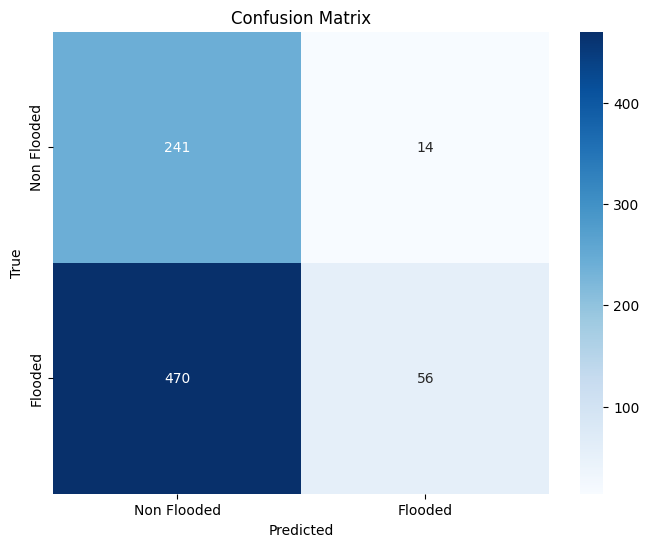

In [32]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

data_dir = r"D:\Datasets\AIDER\classification"
target_size = (224, 224)
batch_size = 32

classes = sorted(os.listdir(data_dir))

X_data = []
y_data = []

for class_label in classes:
    class_path = os.path.join(data_dir, class_label)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        X_data.append(img_array)
        y_data.append(classes.index(class_label))

X_test = np.array(X_data)
y_test = np.array(y_data)

random_seed = 42
np.random.seed(random_seed)

indices = np.arange(len(X_test))
np.random.shuffle(indices)

X_test = X_test[indices]
y_test = y_test[indices]

X_test = X_test / 255.0
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(classes))

y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate a classification report
print('Classification Report:')
print(classification_report(y_true_classes, y_pred_classes))

# Generate a confusion matrix
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
print('Confusion Matrix:')
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Test Data of our own dataset

8/8 [==============================] - 1s 88ms/step
Accuracy: 50.21%
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.95      0.64       110
           1       0.76      0.12      0.21       131

    accuracy                           0.50       241
   macro avg       0.62      0.54      0.42       241
weighted avg       0.63      0.50      0.40       241

Confusion Matrix:


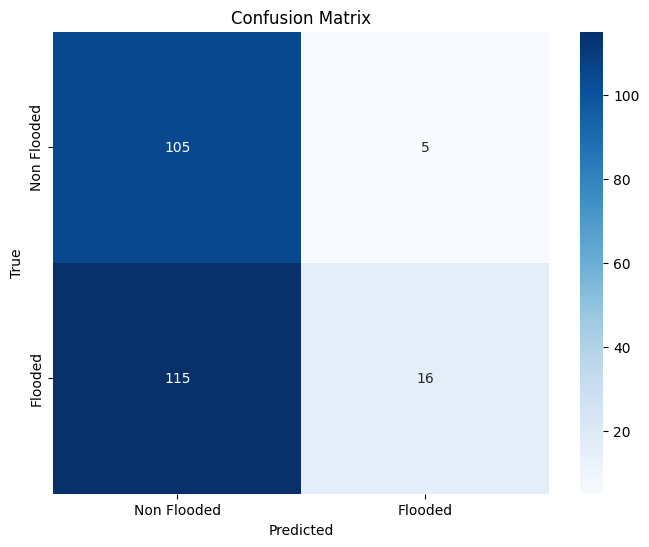

In [31]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

data_dir = r"D:\Datasets\Classification\A\test"
target_size = (224, 224)
batch_size = 32

classes = sorted(os.listdir(data_dir))

X_data = []
y_data = []

for class_label in classes:
    class_path = os.path.join(data_dir, class_label)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        X_data.append(img_array)
        y_data.append(classes.index(class_label))

X_test = np.array(X_data)
y_test = np.array(y_data)

random_seed = 42
np.random.seed(random_seed)

indices = np.arange(len(X_test))
np.random.shuffle(indices)

X_test = X_test[indices]
y_test = y_test[indices]

X_test = X_test / 255.0
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(classes))

y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate a classification report
print('Classification Report:')
print(classification_report(y_true_classes, y_pred_classes))

# Generate a confusion matrix
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
print('Confusion Matrix:')
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()